In [39]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(2806) # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
#from keras.layers import containers
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.utils import np_utils

from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

batch_size = 64
nb_classes = 10
nb_epoch = 1

# the data, shuffled and split between train and test sets
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [2]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### AE without regularizers

In [132]:
input_img = Input(shape=(784,))

nr_encoded = Dense(32, activation='relu')(input_img)
#nr_encoded = Dense(64, activation='relu')(nr_encoded)
#nr_encoded = Dense(32, activation='relu')(nr_encoded)

#nr_decoded = Dense(64, activation='relu')(nr_encoded)
#nr_decoded = Dense(128, activation='relu')(nr_encoded)
nr_decoded = Dense(784, activation='sigmoid')(nr_encoded)

ae_no_reg = Model(input_img, nr_decoded)
ae_no_reg.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
no_reg_train = ae_no_reg.fit(X_train_noisy, X_train,
                epochs=300,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noisy, X_test))

In [134]:
nr_encoder = Model(input_img, nr_encoded)
# create a placeholder for an encoded (32-dimensional) input
nr_encoded_input = Input(shape=(32,))
# retrieve the last layer of the autoencoder model
nr_decoder_layer = ae_no_reg.layers[-1:]
# create the decoder model
# nr_decoder = Model(nr_encoded_input, nr_decoder_layer[2](nr_decoder_layer[1](nr_decoder_layer[0](nr_encoded_input))))
nr_decoder = Model(nr_encoded_input, nr_decoder_layer[0](nr_encoded_input))

nr_encoded_imgs = nr_encoder.predict(X_test)
nr_decoded_imgs = nr_decoder.predict(nr_encoded_imgs)

### AE with regularizers (Representation / Kernel)

In [125]:
from keras import regularizers

input_img = Input(shape=(784,))

# Use one of the following two. All the cells following including the analysis depends on
# the regularization layer chosen in this block 

# Kernel Regularizer for weights and Biases
r_encoded = Dense(32, activation='relu', bias_regularizer=regularizers.l1(1e-5)
                  , kernel_regularizer=regularizers.l1(1e-5))(input_img)
# Activity Regularizer for Encoded Representation
# r_encoded = Dense(32, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5))(input_img)

r_decoded = Dense(784, activation='sigmoid')(r_encoded)

ae_reg = Model(input_img, r_decoded)
ae_reg.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
reg_train = ae_reg.fit(X_train_noisy, X_train,
                epochs=300,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noisy, X_test))

In [127]:
r_encoder = Model(input_img, r_encoded)
# create a placeholder for an encoded (32-dimensional) input
r_encoded_input = Input(shape=(32,))
# retrieve the last layer of the autoencoder model
r_decoder_layer = ae_reg.layers[-1:]
# create the decoder model
#r_decoder = Model(r_encoded_input, r_decoder_layer[2](r_decoder_layer[1](r_decoder_layer[0](r_encoded_input))))
r_decoder = Model(r_encoded_input, r_decoder_layer[0](r_encoded_input))

r_encoded_imgs = r_encoder.predict(X_test)
r_decoded_imgs = r_decoder.predict(r_encoded_imgs)

### Deep/ Stacked AE

In [139]:
from keras import regularizers

input_img = Input(shape=(784,))

s_encoded = Dense(128, activation='relu')(input_img)
s_encoded = Dense(64, activation='relu')(s_encoded)
s_encoded = Dense(32, activation='relu')(s_encoded)

s_decoded = Dense(64, activation='relu')(s_encoded)
s_decoded = Dense(128, activation='relu')(s_decoded)
s_decoded = Dense(784, activation='sigmoid')(s_decoded)

sae = Model(input_img, s_decoded)
sae.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
s_train = sae.fit(X_train_noisy, X_train,
                epochs=300,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noisy, X_test))

In [141]:
s_encoder = Model(input_img, s_encoded)
# create a placeholder for an encoded (32-dimensional) input
s_encoded_input = Input(shape=(32,))
# retrieve the last layer of the autoencoder model
s_decoder_layer = sae.layers[-3:]
# create the decoder model
s_decoder = Model(s_encoded_input, s_decoder_layer[2](s_decoder_layer[1](s_decoder_layer[0](s_encoded_input))))

s_encoded_imgs = s_encoder.predict(X_test)
s_decoded_imgs = s_decoder.predict(s_encoded_imgs)

In [143]:
nr_pred = ae_no_reg.predict(X_test_noisy)
r_pred = ae_reg.predict(X_test_noisy)
s_pred = sae.predict(X_test_noisy)

nr_mse = mean_squared_error(X_test, nr_pred)
#ra_mse = mean_squared_error(X_test, r_pred) # Activity Reg
rk_mse = mean_squared_error(X_test, r_pred)  # Kernel Reg
s_mse = mean_squared_error(X_test, s_pred)

## Visualizations

In [30]:
#from keras.utils.visualize_util import plot
#plot(model, to_file='data/model.png')
print('AE with Regularizer: \n')
for i in range(0,len(ae_reg.layers)):
    print("Layer: "+str(i)+'\t-'+ str(ae_reg.layers[i].get_output_shape_at(0)) + "\t:" + str(ae_reg.layers[i].name))

print('\nAE without Regularizer: \n')
for i in range(0,len(ae_no_reg.layers)):
    print("Layer: "+str(i)+'\t-'+ str(ae_no_reg.layers[i].get_output_shape_at(0)) + "\t:" + str(ae_no_reg.layers[i].name))

print('\nStacked Autoencoder: \n')
for i in range(0,len(sae.layers)):
    print("Layer: "+str(i)+'\t-'+ str(sae.layers[i].get_output_shape_at(0)) + "\t:" + str(sae.layers[i].name))

AE with Regularizer: 

Layer: 0	-(None, 784)	:input_9
Layer: 1	-(None, 32)	:dense_15
Layer: 2	-(None, 784)	:dense_16

AE without Regularizer: 

Layer: 0	-(None, 784)	:input_1
Layer: 1	-(None, 32)	:dense_1
Layer: 2	-(None, 784)	:dense_2

Stacked Autoencoder: 

Layer: 0	-(None, 784)	:input_12
Layer: 1	-(None, 128)	:dense_23
Layer: 2	-(None, 64)	:dense_24
Layer: 3	-(None, 32)	:dense_25
Layer: 4	-(None, 64)	:dense_26
Layer: 5	-(None, 128)	:dense_27
Layer: 6	-(None, 784)	:dense_28


Input Noisy Data


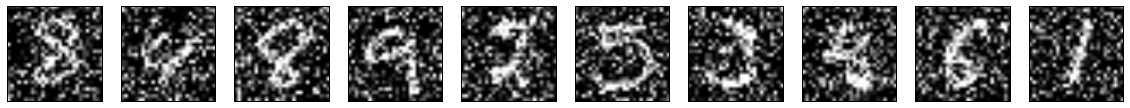

In [229]:
print('Input Noisy Data')
n = 10
plt.figure(figsize=(20, 2))
index = np.random.randint(10000, size=(10))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[index[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Encoded Representation of 400 Samples

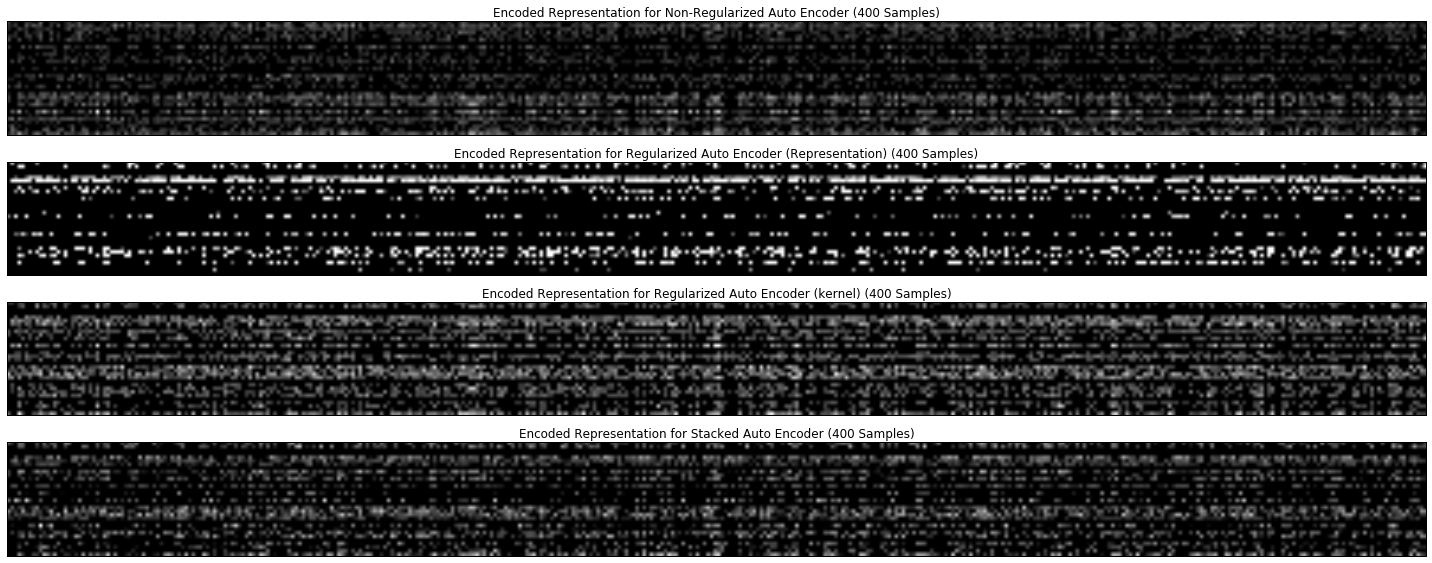

In [91]:
thresh = np.mean(r_encoded_imgs)
i1 = nr_encoded_imgs
#i2 = r_encoded_imgs #kernel regularizer
i4 = r_encoded_imgs #weight regularizer
i3 = s_encoded_imgs
i1[nr_encoded_imgs < thresh] = 0
i2[r_encoded_imgs < thresh] = 0
i3[r_encoded_imgs < thresh] = 0
i4[r_encoded_imgs < thresh] = 0


plt.figure(figsize=(20,8))
plt.gray()

plt.subplot(4,1,1)
plt.imshow(np.abs(np.transpose(i1[0:400,:])))
plt.title('Encoded Representation for Non-Regularized Auto Encoder (400 Samples)')
plt.tick_params(axis='both' ,which='both' ,bottom='off' ,top='off' ,labelbottom='off',
    right='off' ,left='off' ,labelleft='off') # Turn off all the axes labelling

plt.subplot(4,1,2)
plt.imshow(np.abs(np.transpose(i2[0:400,:])))
plt.title('Encoded Representation for Regularized Auto Encoder (Representation) (400 Samples)')
plt.tick_params(axis='both' ,which='both' ,bottom='off' ,top='off' ,labelbottom='off',
    right='off' ,left='off' ,labelleft='off') # Turn off all the axes labelling

plt.subplot(4,1,3)
plt.imshow(np.abs(np.transpose(i4[0:400,:])))
plt.title('Encoded Representation for Regularized Auto Encoder (kernel) (400 Samples)')
plt.tick_params(axis='both' ,which='both' ,bottom='off' ,top='off' ,labelbottom='off',
    right='off' ,left='off' ,labelleft='off') # Turn off all the axes labelling

plt.subplot(4,1,4)
plt.imshow(np.abs(np.transpose(i3[0:400,:])))
plt.title('Encoded Representation for Stacked Auto Encoder (400 Samples)')
plt.tick_params(axis='both' ,which='both' ,bottom='off' ,top='off' ,labelbottom='off',
    right='off' ,left='off' ,labelleft='off') # Turn off all the axes labelling

plt.tight_layout()

# Observation: Activity Regularized autoencoder learns sparse representation of data compared to other forms 
#(blacks indicate 0s; equivalent to sparse)

### Mean value of the encoded Form

In [128]:
#r1 = r_encoded_imgs.mean() # Activity Reg
r2 = r_encoded_imgs.mean() # Kernel Reg
print("\
Mean of non-regularized coded form      : {:6.4f} \n\
Mean of Activity regularized coded form : {:6.4f} \n\
Mean of Kernel regularized coded form   : {:6.4f} \n\
Mean of SAE coded form                  : {:6.4f}"
      .format(nr_encoded_imgs.mean(), r1, r2, s_encoded_imgs.mean()))

Mean of non-regularized coded form      : 3.6074 
Mean of Activity regularized coded form : 0.2583 
Mean of Kernel regularized coded form   : 2.9429 
Mean of SAE coded form                  : 6.4347


### Weight Vector visualized through a grayscale image

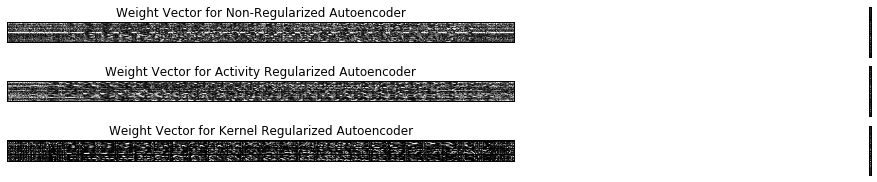

In [98]:
plt.figure(figsize=(20, 3))
plt.gray()
#w1 = np.zeros((1,1,1))
title = ['a','b']
for i in range(1,3):
    w1 = ae_no_reg.layers[i].get_weights()
    #w2 = ae_reg.layers[i].get_weights() #Activity Regularization
    w3 = ae_reg.layers[i].get_weights() #Kernel Regularization

    w1[0] = np.transpose(w1[0])
    w2[0] = np.transpose(w2[0])
    w3[0] = np.transpose(w3[0])
    
    ax = plt.subplot(3,2,i)
    plt.imshow(preprocessing.minmax_scale(np.abs(w1[0])))#.reshape(w1[1].shape[0],1)
    if i == 1:
        plt.title('Weight Vector for Non-Regularized Autoencoder')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3,2,i+2)
    plt.imshow(preprocessing.minmax_scale(np.abs(w2[0])))
    if i == 1:
        plt.title('Weight Vector for Activity Regularized Autoencoder')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3,2,i+4)
    plt.imshow(preprocessing.minmax_scale(np.abs(w3[0])))
    if i == 1:
        plt.title('Weight Vector for Kernel Regularized Autoencoder')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Observation: Weight vectors when sparse indicate dead neurons. AS observed here Kernel Regularized form
# shows sparse network

### Output using different Autoencoders

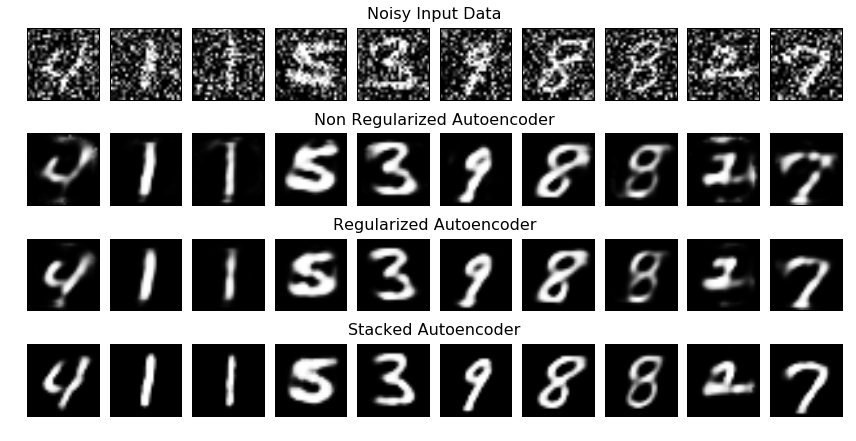

In [228]:
# use Matplotlib (don't ask)
%matplotlib inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display

fig, big_axes = plt.subplots(figsize=(12,6),nrows=4, ncols=1, sharey=True) 
plt.gray()
title = ['Noisy Input Data',  'Non Regularized Autoencoder', 'Regularized Autoencoder', 'Stacked Autoencoder']
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(title[row-1], fontsize=16)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False

#plt.figure(figsize=(20, 4))
for i in range(0,n):
    # display original
    ax = fig.add_subplot(4, n, i + 1)
    plt.imshow(X_test_noisy[index[i]].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    #ax = fig.add_subplot(gs[j+1, i])
    ax = fig.add_subplot(4, n, i + 1 + n)
    plt.imshow(nr_decoded_imgs[index[i]].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = fig.add_subplot(4, n, i + 1 + 2*n)
    plt.imshow(r_decoded_imgs[index[i]].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = fig.add_subplot(4, n, i + 1 + 3*n)
    plt.imshow(s_decoded_imgs[index[i]].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#fig.subplots_adjust(hspace=0.1, wspace=0.5)
    
plt.tight_layout()    
plt.show()

# Observation: The outputs from different networks are comparable. SAE performs the best (300 iterations)

### Mean Squared Errors

In [144]:
print("\
MSE non-regularized AE         : {:6.4f} \n\
MSE Activity regularized AE    : {:6.4f} \n\
MSE Kernel regularized AE      : {:6.4f} \n\
MSE stacked AE                 : {:6.4f}"
      .format(nr_mse, ra_mse, rk_mse, s_mse))

MSE non-regularized AE         : 0.0197 
MSE Activity regularized AE    : 0.0204 
MSE Kernel regularized AE      : 0.0215 
MSE stacked AE                 : 0.0176


### Training Loss

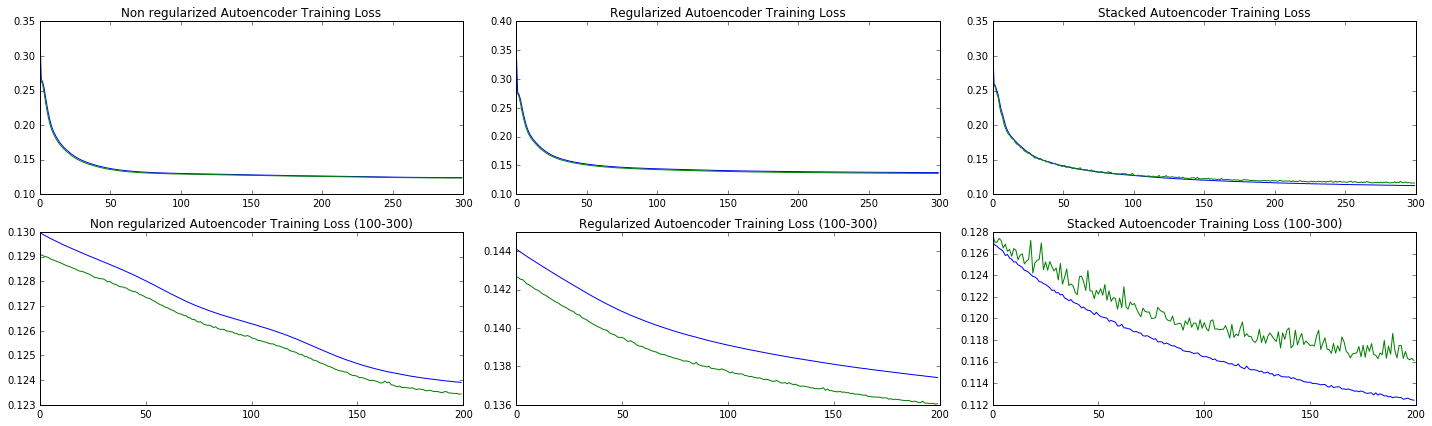

In [150]:
fig = plt.figure(figsize=(20,6))
#train_pred_fit
plt.subplot(2,3,1)
plt.plot(no_reg_train.history['loss'])
plt.plot(no_reg_train.history['val_loss'])
plt.title('Non regularized Autoencoder Training Loss')

plt.subplot(2,3,2)
plt.plot(reg_train.history['loss'])
plt.plot(reg_train.history['val_loss'])
plt.title('Regularized Autoencoder Training Loss')

plt.subplot(2,3,3)
plt.plot(s_train.history['loss'])
plt.plot(s_train.history['val_loss'])
plt.title('Stacked Autoencoder Training Loss')

plt.subplot(2,3,4)
plt.plot(no_reg_train.history['loss'][100:300])
plt.plot(no_reg_train.history['val_loss'][100:300])
plt.title('Non regularized Autoencoder Training Loss (100-300)')

plt.subplot(2,3,5)
plt.plot(reg_train.history['loss'][100:300])
plt.plot(reg_train.history['val_loss'][100:300])
plt.title('Regularized Autoencoder Training Loss (100-300)')

plt.subplot(2,3,6)
plt.plot(s_train.history['loss'][100:300])
plt.plot(s_train.history['val_loss'][100:300])
plt.title('Stacked Autoencoder Training Loss (100-300)')

plt.tight_layout()
plt.show()
# Observation: Generally the non-regularized networks learns much faster than the regularized one. SAE tends
# to overfit over too many iterations (300 in this case)